In [1]:
import os, sys

recsys_story = os.environ.get("RECSYS_STORY")
sys.path.append(recsys_story)
os.chdir(recsys_story)

from lib.tools import *

### spark 

In [2]:
from pyspark import SparkContext, SparkConf, HiveContext
from pyspark.sql import SparkSession
from pyspark.sql.catalog import Catalog

In [3]:
SPARK_CONFIG["process_label"] = "RECSYS_STORY_AB_TEST_DESIGN"
SPARK_CONFIG["numofcores"] = 10
SPARK_CONFIG["numofinstances"] = 6
SPARK_CONFIG["kerberos_auth"] = False

In [4]:
sp = spark(**SPARK_CONFIG)
hive = sp.sql

In [9]:
hive.setConf("hive.input.dir.recursive","true")
hive.setConf("mapred.input.dir.recursive","true")
hive.setConf("hive.supports.subdirectories","true")
hive.setConf("hive.mapred.supports.subdirectories","true")
hive.setConf("mapreduce.input.fileinputformat.input.dir.recursive","true")
# hive.setConf('spark.sql.parquet.binaryAsString', 'true')
# hive.setConf('spark.sql.hive.convertMetastoreParquet', 'false')

hive.setConf('hive.metastore.fshandler.threads', 30)
hive.setConf('hive.msck.repair.batch.size', 1000)
hive.setConf('hive.merge.smallfiles.avgsiz', 256000000)
hive.setConf('hive.merge.size.per.task', 256000000)

In [10]:
SparkConf().getAll()

[('spark.sql.hive.convertMetastoreParquet', 'false'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.sql.parquet.binaryAsString', 'true'),
 ('spark.executor.memory', '30g'),
 ('spark.yarn.driver.memoryOverhead', '4048mb'),
 ('spark.task.maxFailures', '15'),
 ('spark.sql.queryExecutionListeners',
  'com.cloudera.spark.lineage.NavigatorQueryListener'),
 ('spark.sql.shuffle.partitions', '400'),
 ('spark.eventLog.dir', 'hdfs://nsld3/user/spark/spark2ApplicationHistory'),
 ('spark.driver.extraLibraryPath',
  '/opt/workspace/shubochkin1-ei_ca-sbrf-ru/system/support_library/'),
 ('spark.executor.instances', '6'),
 ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
 ('spark.sql.hive.metastore.jars',
  '${env:HADOOP_COMMON_HOME}/../hive/lib/*:${env:HADOOP_COMMON_HOME}/client/*'),
 ('spark.lineage.log.dir', '/var/log/spark2/lineage'),
 ('spark.blacklist.task.maxTaskAttemptsPerNode', '13'),
 ('spark.yarn.historyServer.address',
  'http://pklis-chd001975.labiac.df.sbrf.ru:18089'),


### load_data 

Загрузим кликстрим за 2021 год и определим уникальные даты посещений сббола для каждой ИНН. Таким образов выберем всех юзеров, посещавших СББОЛ в 2021 году (критерием посещения является наличие хотя бы одного события в кликстриме с **hitPageHostName = 'sbi.sberbank.ru'**)

In [10]:
# ctl_loading 2021 year

start_d = '2021-01-01'
end_d = '2022-02-08'

sql_query_ctl = """
SELECT DISTINCT ctl_loading,
                min_sessiondate,
                max_sessiondate
FROM {scheme}.{ctl_table}
WHERE 1=1
  AND (min_sessiondate >= '{start_date}'
       OR max_sessiondate >= '{start_date}')
  AND (min_sessiondate < '{end_date}'
       OR max_sessiondate < '{end_date}')
""".format(scheme=SBX_TEAM_DIGITCAMP,
           ctl_table=GA_VISIT_CTL_DATE_MAP,
           start_date=start_d,
           end_date=end_d)

ctl_loading_list = hive.sql(sql_query_ctl).toPandas()["ctl_loading"]

min_ctl = ctl_loading_list.min()
max_ctl = ctl_loading_list.max()

In [11]:
print(min_ctl, max_ctl, sep='\n')

6099159
15486791


In [10]:
SQL_query_sbbol_clickstream = \
"""
SELECT DISTINCT sbbolUserId,
                sbbolorgguid,
                sessionDate
FROM default.google_analytics_visit
WHERE 1=1
  AND hitPageHostName = 'sbi.sberbank.ru'
  AND ctl_loading >= {min_ctl_loading}
  AND sessionDate >= '{start_d}'
""".format(min_ctl_loading=min_ctl, start_d=start_d)

In [11]:
sbbol_user_visit = hive.sql(SQL_query_sbbol_clickstream).cache()

In [12]:
%%time
sbbol_user_visit.count()

CPU times: user 2.36 s, sys: 1.7 s, total: 4.06 s
Wall time: 5h 9min 36s


157302885

In [13]:
sbbol_user_visit.select(f.min("sessionDate"),
                        f.max("sessionDate")).show()

,min(sessionDate),max(sessionDate)
0,2021-01-01,2022-02-05


In [14]:
# %%time
# drop_table(SBX_TEAM_DIGITCAMP, "tmp_shuben_sbbol_activity", hive)
# create_table_from_df(SBX_TEAM_DIGITCAMP, "tmp_shuben_sbbol_activity", sbbol_user_visit, hive)

CPU times: user 6.1 ms, sys: 0 ns, total: 6.1 ms
Wall time: 15 s


### load table sessions 

In [5]:
sbbol_user_visit = load_table(SBX_TEAM_DIGITCAMP, "tmp_shuben_sbbol_activity", hive).cache()
sbbol_user_visit.count()

157302885

In [6]:
customer_sbbol = load_table(SBX_TEAM_DIGITCAMP, GA_MA_CUSTOMER_SBBOL, hive).cache()
sbbol_inn_visit = customer_sbbol.select("REPLICATIONGUID", f.col("CU_INN").alias("inn"))\
                                .join(sbbol_user_visit,
                                      customer_sbbol.REPLICATIONGUID == sbbol_user_visit.sbbolorgguid,
                                      "inner")\
                                .drop("REPLICATIONGUID", "sbbolorgguid", "sbbolUserId")\
                                .distinct()
            
sbbol_inn_visit = sbbol_inn_visit.filter(~f.isnull("inn")).cache()

In [7]:
%%time
sbbol_inn_visit.count()

CPU times: user 6.63 ms, sys: 5.59 ms, total: 12.2 ms
Wall time: 42.3 s


127512711

In [8]:
sbbol_inn_visit.show()

,inn,sessionDate
0,325700467224,2021-04-26
1,7447271638,2021-09-13
2,1215226112,2021-12-09
3,8602029876,2021-11-08
4,8602029876,2021-03-17
5,8602029876,2021-05-26
6,7701862678,2021-09-20
7,6670443577,2021-10-27
8,7838072310,2021-04-25
9,7130032969,2021-03-25


In [9]:
# %%time
# drop_table(SBX_TEAM_DIGITCAMP, "tmp_shuben_sbbol_inn_activity", hive)
# create_table_from_df(SBX_TEAM_DIGITCAMP, "tmp_shuben_sbbol_inn_activity", sbbol_inn_visit, hive)

CPU times: user 3.14 ms, sys: 2.55 ms, total: 5.69 ms
Wall time: 10.4 s


In [10]:
sbbol_inn_visit = load_table(SBX_TEAM_DIGITCAMP, "tmp_shuben_sbbol_inn_activity", hive).cache()
sbbol_inn_visit.count()

127512711

### analytics common

Видно, что некоторые юзеры заходили под разными юзер айдишниками, но при этом инн один и тот же

In [17]:
sbbol_inn_visit.select("inn").distinct().count()

2120918

In [5]:
sbbol_user_visit.select("sbbolUserId").distinct().count()

2890289

Для начала посмотрим, сколько юзеров заходит в каждый из месяцев

In [18]:
sbbol_inn_visit_month = sbbol_inn_visit.withColumn("month", f.month(f.col("sessionDate")))\
                                       .withColumn("year", f.year(f.col("sessionDate")))\
                                       .select("inn", "month", "year").distinct()

In [19]:
sbbol_inn_visit_month.show()

,inn,month,year
0,5507063832,3,2021
1,661106441805,12,2021
2,7704314221,6,2021
3,7710340340,2,2021
4,5507213206,3,2021
5,710302292108,1,2021
6,2319005624,10,2021
7,1902017942,1,2021
8,860100190411,10,2021
9,2543035930,11,2021


In [20]:
year_visits_sbbol = sbbol_inn_visit_month.groupBy("year", "month")\
                                         .agg(f.countDistinct("inn").alias("users_visit"))\
                                         .toPandas()

In [21]:
year_visits_sbbol_sort = year_visits_sbbol.sort_values(["year", "month"], ascending=True)
year_visits_sbbol_sort

,year,month,users_visit
9,2021,1,1177585
11,2021,2,1184305
7,2021,3,1284510
12,2021,4,1286180
1,2021,5,1177675
0,2021,6,1227495
6,2021,7,1240562
10,2021,8,1192818
4,2021,9,1232826
2,2021,10,1255767


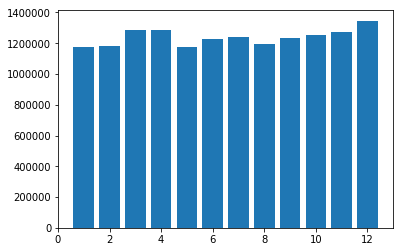

In [22]:
plt.bar(year_visits_sbbol_sort["month"], year_visits_sbbol_sort["users_visit"])
plt.show()

### users activity year

* Теперь посмотрим гистограмму посещений юзеров за год (т.е. сколько раз юзер посещает сайт за год)

* Далее посмотрим посещения за каждый месяц
* За последние 4 месяца

In [23]:
sbbol_inn_visit.show(3)

,inn,sessionDate
0,325700467224,2021-04-26
1,7447271638,2021-09-13
2,1215226112,2021-12-09


In [24]:
inn_activities = sbbol_inn_visit.groupBy("inn").agg(f.countDistinct(f.col("sessionDate")).alias("vistDayCnt"))

In [25]:
inn_activities.count()

2120918

In [26]:
inn_activities_year_pd = inn_activities.select("vistDayCnt").toPandas()

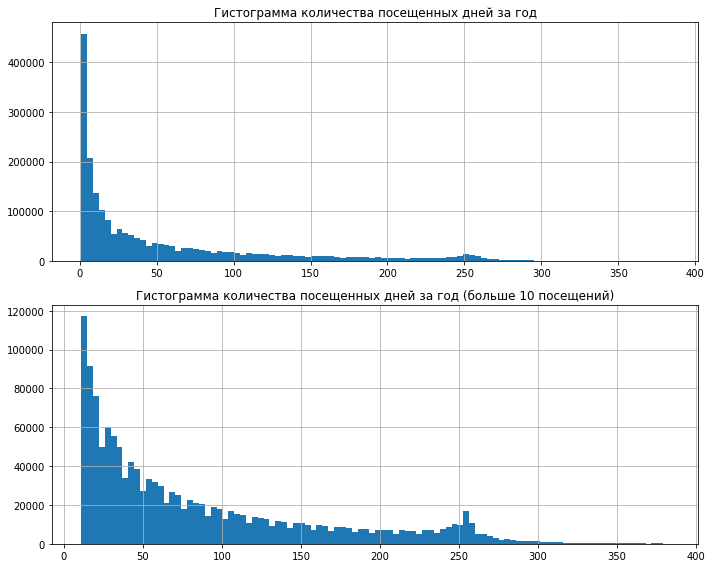

In [53]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.title("Гистограмма количества посещенных дней за год")
plt.hist(inn_activities_year_pd["vistDayCnt"], bins=100)
plt.grid()

plt.subplot(2, 1, 2)
plt.title("Гистограмма количества посещенных дней за год (больше 10 посещений)")
plt.hist(inn_activities_year_pd[inn_activities_year_pd["vistDayCnt"] > 10]["vistDayCnt"], bins=100)
plt.grid()

plt.tight_layout()

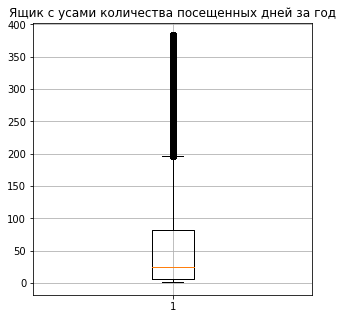

In [39]:
plt.figure(figsize=(5, 5))
plt.title("Ящик с усами количества посещенных дней за год")
plt.boxplot(inn_activities_year_pd["vistDayCnt"])
plt.grid()
plt.show()

### Последние 4 месяца активности

Рассмотрим активность клиентов за последние 4 месяца, также рассмотрим факт последнего посещеия в этом периоде

In [11]:
sbbol_inn_visit_4_month = sbbol_inn_visit.filter("sessionDate >= '2021-09-01'")

In [12]:
sbbol_inn_visit_4_month.select("inn").distinct().count()

1740535

In [13]:
inn_activities_4_month = sbbol_inn_visit_4_month.groupBy("inn")\
                                                  .agg(f.countDistinct(f.col("sessionDate")).alias("vistDayCnt"),
                                                       f.max(f.col("sessionDate")).alias("lastDate"))
inn_activities_4_month_pd = inn_activities_4_month.select("vistDayCnt").toPandas()

Аализ посещения за последние 4 месяца

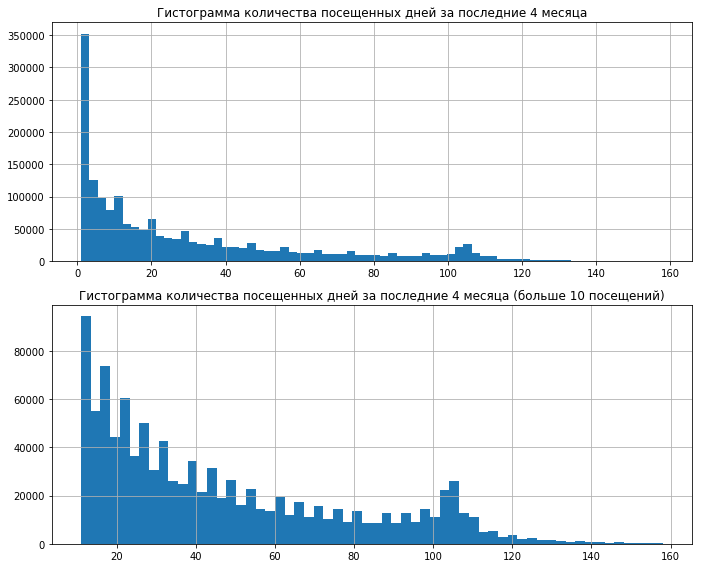

In [14]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.title("Гистограмма количества посещенных дней за последние 4 месяца")
plt.hist(inn_activities_4_month_pd["vistDayCnt"], bins=70)
plt.grid()

plt.subplot(2, 1, 2)
plt.title("Гистограмма количества посещенных дней за последние 4 месяца (больше 10 посещений)")
plt.hist(inn_activities_4_month_pd[inn_activities_4_month_pd["vistDayCnt"] > 10]["vistDayCnt"], bins=60)
plt.grid()

plt.tight_layout()

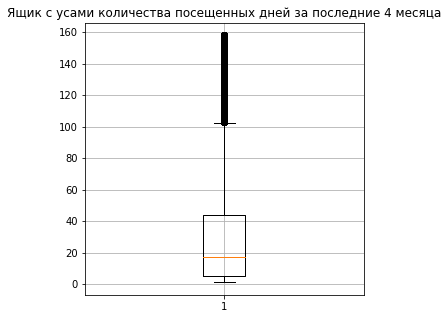

In [15]:
plt.figure(figsize=(5, 5))
plt.title("Ящик с усами количества посещенных дней за последние 4 месяца")
plt.boxplot(inn_activities_4_month_pd["vistDayCnt"])
plt.grid()
plt.show()

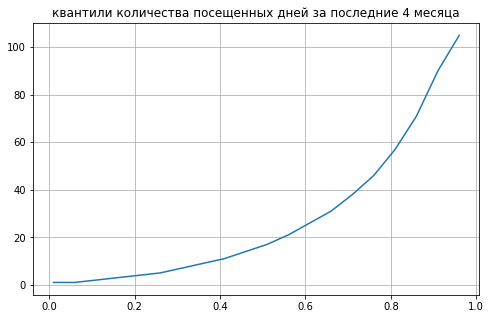

In [16]:
plt.figure(figsize=(8, 5))
plt.title("квантили количества посещенных дней за последние 4 месяца")
i = inn_activities_4_month_pd["vistDayCnt"].quantile([i/ 100 for i in range(1, 100, 5)])
i.T.plot()
plt.grid()
plt.show()

In [17]:
inn_activities_4_month_pd["vistDayCnt"].quantile([0.20, 0.40, 0.60, 0.80])

0.2     3.0
0.4    11.0
0.6    25.0
0.8    54.0
Name: vistDayCnt, dtype: float64

Т.о. можно сделать следующие флаги активности:
- 1-3 посещения за 4 месяца - страта 1
- 4-10 посещений за 4 месяца - страта 2
- 11-23 посещений за 4 месяца - страта 3
- 24-50 посещений за 4 месяца - страта 4
- 50+ посещений за 4 месяца - страта 5

###### последяя дата активности 

In [18]:
last_date_activity = inn_activities_4_month.groupBy(f.col("lastDate")).agg(f.count("inn").alias("inn_cnt_lastDate"))\
                                           .orderBy(f.col("lastDate")).cache()

In [19]:
%%time
last_date_activity.count()

CPU times: user 2.54 ms, sys: 2.24 ms, total: 4.79 ms
Wall time: 8.68 s


158

In [20]:
last_date_activity.show(3)

,lastDate,inn_cnt_lastDate
0,2021-09-01,2523
1,2021-09-02,2676
2,2021-09-03,2466


In [21]:
last_date_activity_pd = last_date_activity.toPandas()

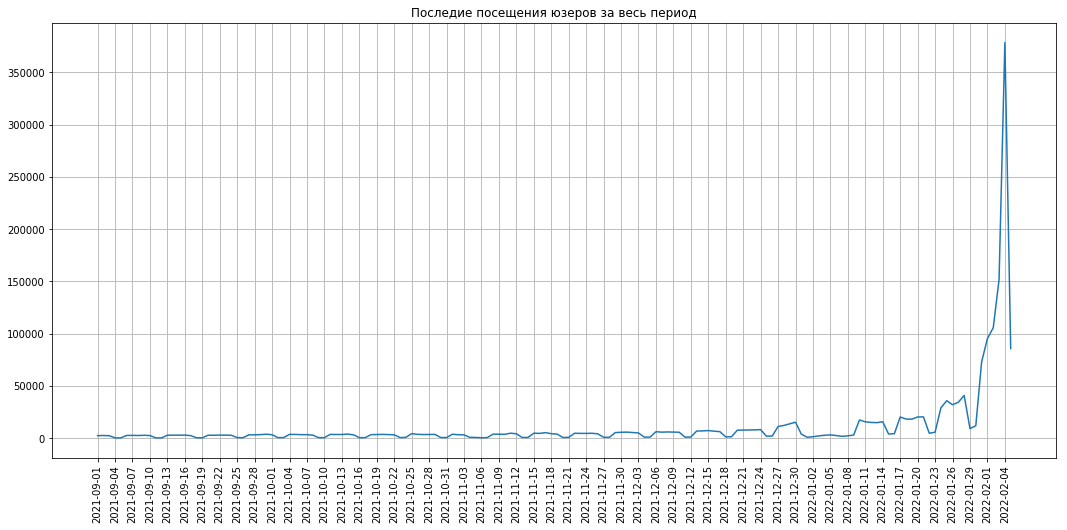

In [22]:
x = last_date_activity_pd["lastDate"]
y = last_date_activity_pd["inn_cnt_lastDate"]


plt.figure(figsize=(18, 8))
plt.title("Последие посещения юзеров за весь период")

plt.plot(x, y)

plt.xticks(x[::3], rotation=90)
plt.grid()
plt.show()

В качестве флага стратификации можно взять дату '2022-01-04', т.е. ровно за месяц

### Страты

In [26]:
inn_with_groups = inn_activities_4_month.withColumn("activity_group", f.when(f.col("vistDayCnt") <= f.lit(3), f.lit(1))\
                                                                       .when(f.col("vistDayCnt") <= f.lit(10), f.lit(2))\
                                                                       .when(f.col("vistDayCnt") <= f.lit(23), f.lit(3))\
                                                                       .when(f.col("vistDayCnt") <= f.lit(50), f.lit(4))\
                                                                       .otherwise(f.lit(5)))\
                                        .withColumn("last_month_flg", f.when(f.col("lastDate") >= f.lit("2022-01-04"), f.lit(1))\
                                                                              .otherwise(0)).cache()

In [27]:
inn_with_groups.count()

1740535

In [28]:
inn_with_groups.show()

,inn,vistDayCnt,lastDate,activity_group,last_month_flg
0,0101012845,5,2022-02-03,2,1
1,010200105600,40,2022-02-03,4,1
2,010401148635,15,2022-01-24,3,1
3,010503128250,12,2022-01-19,3,1
4,0105035949,50,2022-02-04,4,1
5,010518503754,7,2021-12-20,2,0
6,010520023071,2,2021-11-14,1,0
7,0105981150,40,2022-02-03,4,1
8,010604720706,33,2021-10-21,4,0
9,0107029958,106,2022-02-04,5,1


In [29]:
# drop_table(SBX_TEAM_DIGITCAMP, "RECSYS_SBBOL_INN_STRATIFICATION", hive)
# create_table_from_df(SBX_TEAM_DIGITCAMP, "RECSYS_SBBOL_INN_STRATIFICATION", inn_with_groups, hive)

In [30]:
inn_with_groups = load_table(SBX_TEAM_DIGITCAMP, "RECSYS_SBBOL_INN_STRATIFICATION", hive).cache()

Видим, что группы юзеров разбиты равномерно, в каждой по 350к юзеров

In [31]:
inn_with_groups.groupBy("activity_group").agg(f.count(f.col("inn")).alias("cnt_users"))\
               .orderBy(f.col("activity_group")).show()

,activity_group,cnt_users
0,1,352194
1,2,338804
2,3,327657
3,4,343474
4,5,378406


In [77]:
agg_group_sdf = inn_with_groups.groupBy("activity_group",
                                        "last_month_flg").agg(f.count(f.col("inn")).alias("cnt_users"))\
                               .orderBy(f.col("activity_group"), "last_month_flg")

Посмотрим на разбиение юзеров с флагом активности посещения за последний месяц

In [86]:
agg_group_sdf.groupBy("activity_group").pivot("last_month_flg")\
             .agg(f.sum("cnt_users"))\
             .orderBy("activity_group").show()

,activity_group,0,1
0,1,243386,109573
1,2,114016,234358
2,3,28552,306868
3,4,7405,329897
4,5,1201,334569


### analys_story_clicks 

Теперь посмотрим, как распределены показатели кликов по сторям в СББОЛе в стратах за декабрь. Для этого получим все клики по сторям. (Конечно, лучше смотреть продуктовые стори, но сейчас посмотрим на все стори). Каждому ИНН проставляется флаг - 1, если за прошедший период у него имелся клик по сторе. Т.о. посмотрим на среднее и дисперсию вероятности клика по сторе за декабрь

In [5]:
inn_with_groups = load_table(SBX_TEAM_DIGITCAMP, "RECSYS_SBBOL_INN_STRATIFICATION", hive).cache()
inn_with_groups.count()

1709825

In [6]:
inn_with_groups.show()

,inn,vistDayCnt,lastDate,activity_group,last_month_flg
0,0101012845,4,2022-01-03,2,1
1,010200105600,37,2022-01-20,4,1
2,010401148635,14,2022-01-20,3,1
3,010503128250,12,2022-01-19,3,1
4,0105035949,44,2022-01-14,4,1
5,010518503754,7,2021-12-20,2,1
6,010520023071,2,2021-11-14,1,0
7,0105981150,37,2022-01-17,4,1
8,010604720706,33,2021-10-21,4,0
9,0107029958,95,2022-01-20,5,1


In [89]:
# ctl_loading DEC 2021

start_d = '2021-12-01'
end_d = '2022-01-01'

sql_query_ctl = """
SELECT DISTINCT ctl_loading
FROM {scheme}.{ctl_table}
WHERE 1=1
  AND (min_sessiondate >= '{start_date}'
       OR max_sessiondate >= '{start_date}')
  AND (min_sessiondate < '{end_date}'
       OR max_sessiondate < '{end_date}')
""".format(scheme=SBX_TEAM_DIGITCAMP,
           ctl_table=GA_VISIT_CTL_DATE_MAP,
           start_date=start_d,
           end_date=end_d)

ctl_loading_list = hive.sql(sql_query_ctl).toPandas()["ctl_loading"]

min_ctl = ctl_loading_list.min()
max_ctl = ctl_loading_list.max()

In [90]:
SQL_query_sbbol_dec_story_clicks = \
"""
SELECT sbbolUserId,
       sbbolorgguid,
       hitType,
       eventCategory,
       eventAction,
       eventLabel,
       sessionDate
                
FROM prx_google_analytics_part_external_google_analytics.visit
WHERE 1=1
  AND hitPageHostName = 'sbi.sberbank.ru'
  AND hitType like '%EVENT%'
  AND eventCategory = '[operations]: offers'
  AND eventAction = 'open card'
  AND eventLabel like '%[placement: main[main_feed]]%'
  AND ctl_loading >= {min_ctl_loading}
  AND ctl_loading < {max_ctl_loading}
  AND sessionDate >= '{start_d}'
  AND sessionDate < '{end_d}'
""".format(min_ctl_loading=min_ctl,
           max_ctl_loading=max_ctl,
           start_d=start_d,
           end_d=end_d)

In [91]:
sbbol_story_clicks_clickstream = hive.sql(SQL_query_sbbol_dec_story_clicks).cache()

In [92]:
%%time
sbbol_story_clicks_clickstream.count()

CPU times: user 42.9 ms, sys: 17.1 ms, total: 60 ms
Wall time: 3min 41s


131488

In [93]:
def clickstream_parse_products(clickstream_uniq):
        pattern1 = 'product\: [^]]*]{1}'
        pattern2 = 'product\: [^,]*,{1}'
        clickstream_product = clickstream_uniq.withColumn('product',f.regexp_extract("eventLabel", pattern1, 0))\
                                              .withColumn('product',
                                                          f.when(f.col("product").like("%,%"),
                                                          f.regexp_extract("eventLabel", pattern2, 0))\
                                              .otherwise(f.col("product")))
        clickstream_product = clickstream_product.withColumn("product",
                                                             f.col("product").substr(f.lit(10), f.length("product") - 10))
        return clickstream_product

In [94]:
sbbol_story_clicks_products = clickstream_parse_products(sbbol_story_clicks_clickstream).select("sbbolorgguid",
                                                                                                "product")\
                                                                                        .distinct().cache()

In [95]:
sbbol_story_clicks_products.show()

,sbbolorgguid,product
0,85f24b5e-15d7-452a-b6bb-e0828e65e74c,e_inv
1,6a9743cc-e2a1-4fe9-9f86-0c63e4ca6687,none
2,b6a0388d-e34a-469b-a267-37aaad2722de,none
3,dbb65285-d8db-4f3b-b25f-f919eeb3079d,none
4,b218b59e-fe37-4d60-a2d9-752dfbf7a101,korpkarta
5,251613b4-f25d-4ce0-810b-d775ee6668a4,none
6,03b6402c-4865-4a1f-b5e0-c659d33a0ea5,sms
7,9e9a988f-f3f7-4eaf-931a-6329861d7bfc,none
8,424dcc98-b8d7-49aa-b4af-932ffddc331d,mybuch_online_sso
9,39e1e45c-7867-4124-a717-c10f799bea5c,none


In [27]:
# sbbol_story_clicks_products = sbbol_story_clicks_products.filter("product <> 'none'")

###### inn match 

In [96]:
customer_sbbol = load_table(SBX_TEAM_DIGITCAMP, GA_MA_CUSTOMER_SBBOL, hive).cache()
sbbol_inn_story_click = customer_sbbol.select("REPLICATIONGUID", f.col("CU_INN").alias("inn"))\
                                .join(sbbol_story_clicks_products,
                                      customer_sbbol.REPLICATIONGUID == sbbol_story_clicks_clickstream.sbbolorgguid,
                                      "inner")\
                                .drop("REPLICATIONGUID", "sbbolorgguid")\
                                .select("inn", "product")\
                                .distinct()
            
sbbol_inn_story_click = sbbol_inn_story_click.filter(~f.isnull("inn")).cache()

In [100]:
sbbol_inn_story_click.count()

87400

In [98]:
inn_with_story_click = sbbol_inn_story_click.select("inn").distinct().cache()
inn_with_story_click.count()

73380

###### show ctr in strats 

In [102]:
inn_strats_clicks = inn_with_groups.alias("strats").join(inn_with_story_click.alias("clicks"),
                                                         inn_with_story_click.inn == inn_with_groups.inn,
                                                         "left").select(f.col("strats.inn"),
                                                                        f.col("strats.activity_group"),
                                                                        f.col("strats.last_month_flg"),
                                                                        f.when(f.col("clicks.inn").isNull(),
                                                                               f.lit(0))\
                                                                         .otherwise(f.lit(1)).alias("story_click_flg")).cache()

In [103]:
inn_strats_clicks.show()

,inn,activity_group,last_month_flg,story_click_flg
0,0101012845,2,1,0
1,010200105600,4,1,0
2,010401148635,3,1,0
3,010503128250,3,1,1
4,0105035949,4,1,0
5,010518503754,2,1,0
6,010520023071,1,0,0
7,0105981150,4,1,0
8,010604720706,4,0,0
9,0107029958,5,1,0


In [104]:
inn_strats_clicks.filter("story_click_flg = 1").count()

73380

In [107]:
inn_strats_clicks.groupBy("activity_group").agg(f.count("inn").alias("inn_cnt"),
                                                              f.sum("story_click_flg").alias("inn_click_cnt"),
                                                              f.mean("story_click_flg").alias("prob_click"))\
                 .orderBy("activity_group").show()

,activity_group,inn_cnt,inn_click_cnt,prob_click
0,1,352959,5602,0.015872
1,2,348374,11891,0.034133
2,3,335420,15192,0.045292
3,4,337302,17689,0.052443
4,5,335770,23006,0.068517


In [108]:
inn_strats_clicks.groupBy("activity_group").pivot("last_month_flg").agg(f.count("inn").alias("inn_cnt"),
                                                              f.sum("story_click_flg").alias("inn_click_cnt"),
                                                              f.mean("story_click_flg").alias("prob_click"))\
                 .orderBy("activity_group").show()

,activity_group,0_inn_cnt,0_inn_click_cnt,0_prob_click,1_inn_cnt,1_inn_click_cnt,1_prob_click
0,1,243386,2497,0.010259,109573,3105,0.028337
1,2,114016,1772,0.015542,234358,10119,0.043178
2,3,28552,525,0.018388,306868,14667,0.047796
3,4,7405,168,0.022687,329897,17521,0.053111
4,5,1201,54,0.044963,334569,22952,0.068602


Таким образом видим, что среди страт самый высокий CTR у наиболее активных юзеров, то есть данная стратификация является достаточно хорошей.

### export to ISKRA 

In [7]:
inn_with_groups.show()

,inn,vistDayCnt,lastDate,activity_group,last_month_flg
0,0101012845,4,2022-01-03,2,1
1,010200105600,37,2022-01-20,4,1
2,010401148635,14,2022-01-20,3,1
3,010503128250,12,2022-01-19,3,1
4,0105035949,44,2022-01-14,4,1
5,010518503754,7,2021-12-20,2,1
6,010520023071,2,2021-11-14,1,0
7,0105981150,37,2022-01-17,4,1
8,010604720706,33,2021-10-21,4,0
9,0107029958,95,2022-01-20,5,1


In [11]:
sdf = inn_with_groups

In [12]:
db = OracleDB('iskra4')
mode = 'append'

In [13]:
typesmap={}
for column_name, column in sdf.dtypes:
    if column == 'string':
        if 'INN' in column_name.upper() or 'KPP' in column_name:
            typesmap[column_name] = 'VARCHAR(20)'
        elif 'PRODUCTS'.upper() in column_name:
            typesmap[column_name] = 'VARCHAR(4000)'
        else:
            typesmap[column_name] = 'VARCHAR(70)'
    elif column == 'int':
        typesmap[column_name] = 'INTEGER'
    elif column == 'bigint':
        typesmap[column_name] = 'INTEGER'
    elif column == 'timestamp':
        typesmap[column_name] = 'DATE'
    elif column == 'float' or column == 'double':
        typesmap[column_name] = 'FLOAT'
    else:
        None

In [14]:
cols = ', '.join([col + ' ' + typesmap[col] for col in sdf.columns])

In [15]:
sdf.write \
    .format('jdbc') \
    .mode(mode) \
    .option('url', 'jdbc:oracle:thin:@//'+db.dsn) \
    .option('user', db.user) \
    .option('password', db.password) \
    .option('dbtable', "RECSYS_SBBOL_INN_STRATIFICATION") \
    .option('createTableColumnTypes', cols)\
    .option('driver', 'oracle.jdbc.driver.OracleDriver') \
    .save()

### check iskra 

In [17]:
hive.read.format('jdbc')\
    .option('url', 'jdbc:oracle:thin:@//' + db.dsn) \
    .option('user', db.user) \
    .option('password', db.password) \
    .option('dbtable', "RECSYS_SBBOL_INN_STRATIFICATION") \
    .option('driver', 'oracle.jdbc.driver.OracleDriver')\
    .load().count()

1709825